In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/potato/QVI_purchase_behaviour.csv
/kaggle/input/potato/QVI_transaction_data.xlsx


In [ ]:
# Set the style for all visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

In [2]:
# Load and perform initial cleaning of the data

# Load transaction data
trans_df = pd.read_excel('../input/potato/QVI_transaction_data.xlsx')
    


In [6]:
# Check the data type of the DATE column
print(trans_df['DATE'].dtype)

datetime64[ns]


In [7]:
print(trans_df['DATE'].iloc[0])

2018-10-17 00:00:00


In [9]:
# Check for missing values
missing_values1 = trans_df.isnull().sum()
print("Missing Values:\n", missing_values1)

Missing Values:
 DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


In [10]:
trans_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [11]:
# get all the unique values in the 'Country' column
product_name = trans_df['PROD_NAME'].unique()

# sort them alphabetically and then take a closer look
product_name.sort()
product_name

array(['Burger Rings 220g', 'CCs Nacho Cheese    175g',
       'CCs Original 175g', 'CCs Tasty Cheese    175g',
       'Cheetos Chs & Bacon Balls 190g', 'Cheetos Puffs 165g',
       'Cheezels Cheese 330g', 'Cheezels Cheese Box 125g',
       'Cobs Popd Sea Salt  Chips 110g',
       'Cobs Popd Sour Crm  &Chives Chips 110g',
       'Cobs Popd Swt/Chlli &Sr/Cream Chips 110g',
       'Dorito Corn Chp     Supreme 380g',
       'Doritos Cheese      Supreme 330g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Doritos Corn Chips  Cheese Supreme 170g',
       'Doritos Corn Chips  Nacho Cheese 170g',
       'Doritos Corn Chips  Original 170g', 'Doritos Mexicana    170g',
       'Doritos Salsa       Medium 300g', 'Doritos Salsa Mild  300g',
       'French Fries Potato Chips 175g',
       'Grain Waves         Sweet Chilli 210g',
       'Grain Waves Sour    Cream&Chives 210G',
       'GrnWves Plus Btroot & Chilli Jam 180g',
       'Infuzi

In [12]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.2+ MB


In [14]:
# Extract year, month, day, etc.
trans_df['YEAR'] = trans_df['DATE'].dt.year
trans_df['MONTH'] = trans_df['DATE'].dt.month
trans_df['DAY'] = trans_df['DATE'].dt.day

In [18]:
 # Load customer behavior data
cust_df = pd.read_csv('../input/potato/QVI_purchase_behaviour.csv')

In [19]:
cust_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


In [20]:
# Check for missing values
missing_values2 = cust_df.isnull().sum()
print("Missing Values:\n", missing_values2)

Missing Values:
 LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64


In [21]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [23]:
# Analyze customer segments and their distribution

# Customer segments analysis
lifestage_dist = cust_df['LIFESTAGE'].value_counts()
premium_dist = cust_df['PREMIUM_CUSTOMER'].value_counts()
    
# Create cross-tabulation
segment_crosstab = pd.crosstab(cust_df['LIFESTAGE'], 
                                cust_df['PREMIUM_CUSTOMER'])

In [24]:
# Analyze transaction patterns and merge with customer data

# Merge transaction data with customer segments
merged_df = pd.merge(trans_df, cust_df, on='LYLTY_CARD_NBR', how='left')
    
# Calculate key metrics
metrics = {
    'total_sales': merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum(),
    'avg_basket_size': merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].mean(),
    'transaction_count': merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).size()
}
    
# Analyze sales patterns over time
daily_sales = merged_df.groupby('DATE')['TOT_SALES'].sum().reset_index()

Text(0.5, 1.0, 'Customer Segment Cross-tabulation')

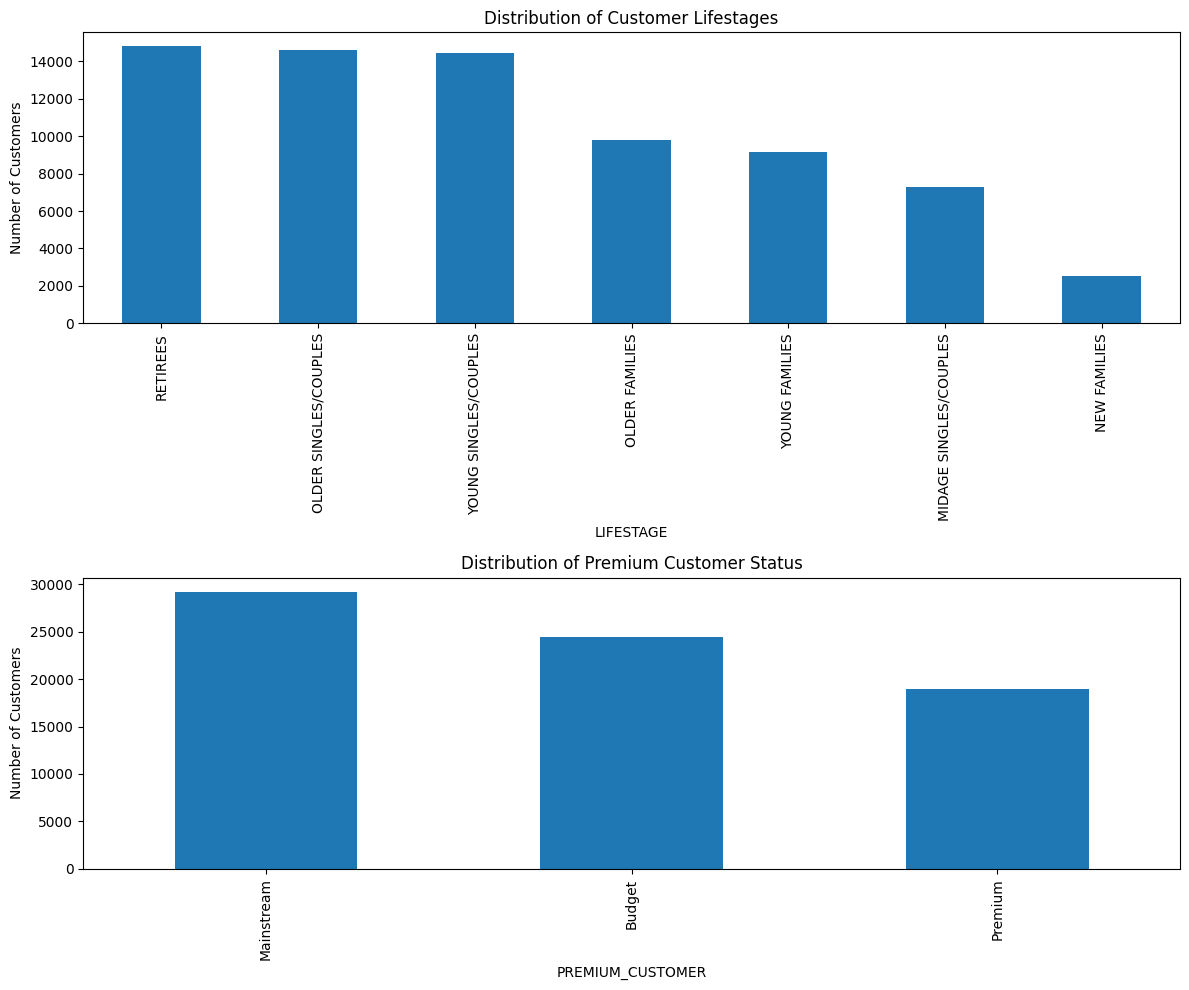

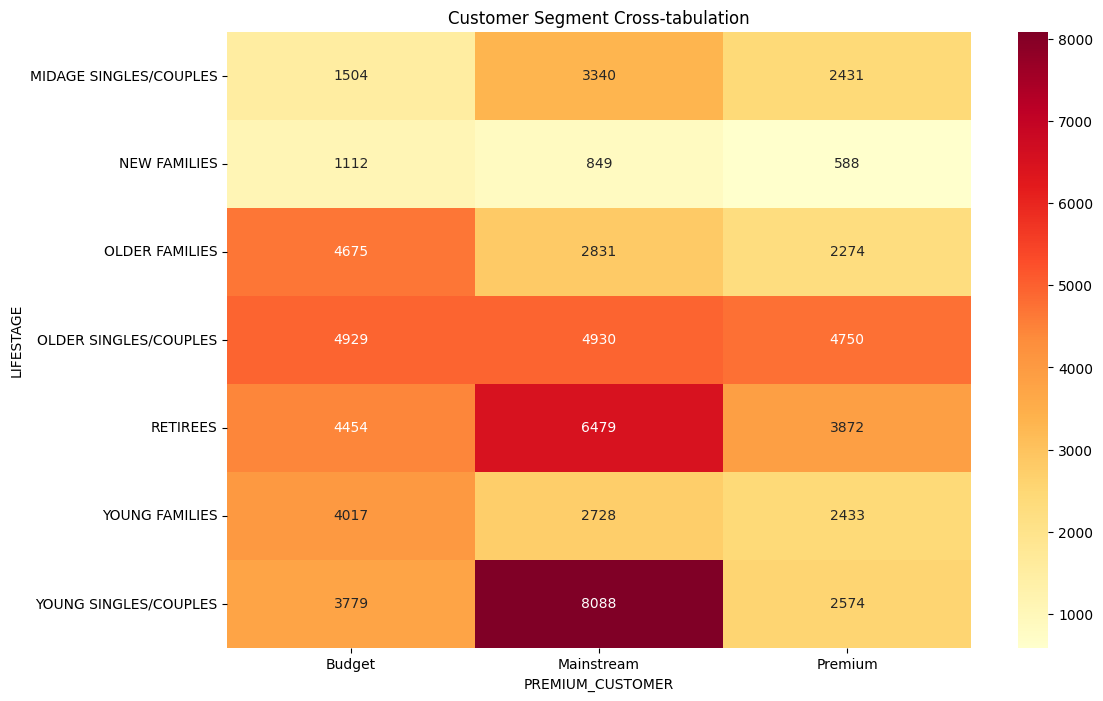

In [25]:
# Create visualizations for customer segments

# Set up the plotting area
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
# Plot lifestage distribution
lifestage_dist.plot(kind='bar', ax=ax1)
ax1.set_title('Distribution of Customer Lifestages')
ax1.set_ylabel('Number of Customers')
plt.xticks(rotation=45)
    
# Plot premium customer distribution
premium_dist.plot(kind='bar', ax=ax2)
ax2.set_title('Distribution of Premium Customer Status')
ax2.set_ylabel('Number of Customers')
    
plt.tight_layout()
    
# Create heatmap for segment cross-tabulation
plt.figure(figsize=(12, 8))
sns.heatmap(segment_crosstab, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Customer Segment Cross-tabulation')
    

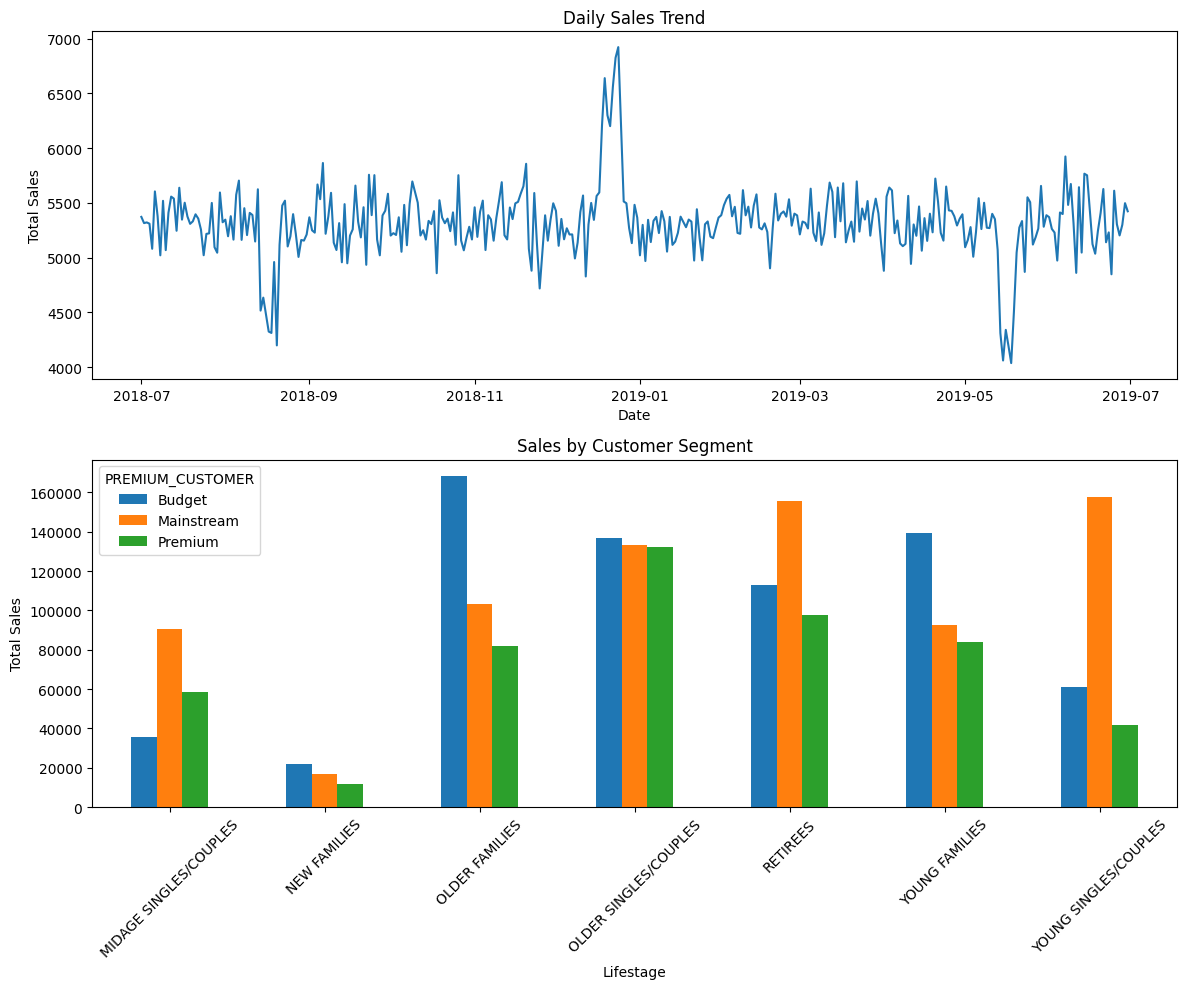

In [26]:
# Create visualizations for sales patterns
# Plot sales trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
# Daily sales trend
ax1.plot(daily_sales['DATE'], daily_sales['TOT_SALES'])
ax1.set_title('Daily Sales Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales')
    
# Sales by customer segment
segment_sales = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().unstack()
segment_sales.plot(kind='bar', ax=ax2)
ax2.set_title('Sales by Customer Segment')
ax2.set_xlabel('Lifestage')
ax2.set_ylabel('Total Sales')
plt.xticks(rotation=45)
    
plt.tight_layout()

In [28]:
# Identify and analyze outliers in the data

# Calculate outliers for sales and quantity
sales_Q1 = merged_df['TOT_SALES'].quantile(0.25)
sales_Q3 = merged_df['TOT_SALES'].quantile(0.75)
sales_IQR = sales_Q3 - sales_Q1
    
qty_Q1 = merged_df['PROD_QTY'].quantile(0.25)
qty_Q3 = merged_df['PROD_QTY'].quantile(0.75)
qty_IQR = qty_Q3 - qty_Q1
    
outliers = {
    'sales': merged_df[
        (merged_df['TOT_SALES'] < (sales_Q1 - 1.5 * sales_IQR)) |
        (merged_df['TOT_SALES'] > (sales_Q3 + 1.5 * sales_IQR))
    ],
    'quantity': merged_df[
        (merged_df['PROD_QTY'] < (qty_Q1 - 1.5 * qty_IQR)) |
        (merged_df['PROD_QTY'] > (qty_Q3 + 1.5 * qty_IQR))
    ]
}

In [29]:
# Print summary statistics
print("\nCustomer Segment Summary:")
print(f"Total number of customers: {len(cust_df)}")
print("\nTransaction Summary:")
print(f"Total number of transactions: {len(trans_df)}")
print(f"Date range: {trans_df['DATE'].min()} to {trans_df['DATE'].max()}")
    
# Print outlier summary
print("\nOutlier Summary:")
print(f"Number of sales outliers: {len(outliers['sales'])}")
print(f"Number of quantity outliers: {len(outliers['quantity'])}")


Customer Segment Summary:
Total number of customers: 72637

Transaction Summary:
Total number of transactions: 264836
Date range: 2018-07-01 00:00:00 to 2019-06-30 00:00:00

Outlier Summary:
Number of sales outliers: 578
Number of quantity outliers: 28797
